In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
from tqdm import tqdm
import seaborn as sns
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Update your data_transform for training and testing to upscale images
data_transform_upscaled = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 64

# Load the dataset with transforms
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=data_transform_upscaled)

# Dataset split into training, validation, and testing set
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in train_loader:
    print(image.shape[1])
    break

3


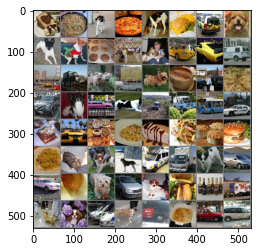

food  food  dogs  food  dogs  food  vehicles dogs  dogs  dogs  food  dogs  dogs  vehicles vehicles vehicles vehicles vehicles dogs  vehicles dogs  food  vehicles food  vehicles dogs  vehicles dogs  vehicles vehicles vehicles vehicles food  vehicles food  food  food  food  food  food  food  dogs  dogs  dogs  vehicles vehicles dogs  vehicles vehicles food  dogs  vehicles dogs  food  food  vehicles dogs  dogs  vehicles dogs  vehicles food  vehicles vehicles


In [4]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [7]:
torch.cuda.empty_cache()

Below are the details of Vision Transformer model variants:

Model Layers Hidden size D MLP size Heads Params
ViT-Base 12 768 3072 12 86M
ViT-Large 24 1024 4096 16 307M
ViT-Huge 32 1280 5120 16 632M

Among the above variant, we're implementing ViT Base model

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embedding(x)  # [batch_size, embed_dim, num_patches_h, num_patches_w]
        x = x.permute(0, 2, 3, 1)  # [batch_size, num_patches_h, num_patches_w, embed_dim]
        x = x.view(x.size(0), -1, self.embed_dim)  # [batch_size, num_patches, embed_dim]
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.2):  # added dropout
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)  # added dropout layer

    def forward(self, query, key, value):
        batch_size = query.size(0)

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, head_dim]
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        x = torch.matmul(self.dropout(attention_weights), V)  # added dropout
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.embed_dim)
        x = self.fc_out(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.2):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout=dropout)  # added dropout
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),  # added dropout
            nn.Linear(mlp_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_output = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))
        mlp_output = self.mlp(x)
        x = self.norm2(x + self.dropout(mlp_output))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, embed_dim * 4) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [9]:
image_size = 64
patch_size = 16
in_channels = 3
embed_dim = 768
num_heads = 12
num_layers = 12
num_classes = 3

ViT_base_model = VisionTransformer(image_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes)
print("Model Summary:")
print(ViT_base_model)

Model Summary:
VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (fc_out): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout

In [10]:
def modelTraining(model, criterion, optimizer):

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        training_loss_plt_arr.append(train_loss)

        # Validation phase
        validation_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * images.size(0)

        validation_loss = validation_loss / len(val_loader.dataset)
        validation_loss_plt_arr.append(validation_loss)

        # Testing phase
        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)

        test_loss = test_loss / len(test_loader.dataset)
        testing_loss_plt_arr.append(test_loss)
                
        # Print training, validation loss and testing loss
        if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Test Loss: {test_loss:.4f}")

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [11]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [12]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    trueLabels, predictedLabels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            trueLabels.extend(labels.cpu().numpy())
            predictedLabels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(trueLabels, predictedLabels)
    return accuracy, trueLabels, predictedLabels

def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    bars = plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    # Adjust text position to be above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

Epoch 1/10, Train Loss: 0.6376, Validation Loss: 0.5529, Test Loss: 0.5533
Epoch 2/10, Train Loss: 0.5109, Validation Loss: 0.5035, Test Loss: 0.5108
Epoch 3/10, Train Loss: 0.4637, Validation Loss: 0.5391, Test Loss: 0.5623
Epoch 4/10, Train Loss: 0.4281, Validation Loss: 0.4231, Test Loss: 0.4357
Epoch 5/10, Train Loss: 0.3950, Validation Loss: 0.4057, Test Loss: 0.4154
Epoch 6/10, Train Loss: 0.3680, Validation Loss: 0.4410, Test Loss: 0.4645
Epoch 7/10, Train Loss: 0.3444, Validation Loss: 0.3791, Test Loss: 0.4055
Epoch 8/10, Train Loss: 0.3216, Validation Loss: 0.4511, Test Loss: 0.4863
Epoch 9/10, Train Loss: 0.2905, Validation Loss: 0.4295, Test Loss: 0.4650
Epoch 10/10, Train Loss: 0.2569, Validation Loss: 0.4101, Test Loss: 0.4360
Finished Training

Time to train: 5min 11sec


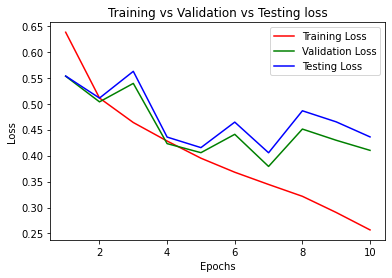

Accuracy on the testing dataset = 0.85
Precision = 0.86
Recall = 0.85
Fscore = 0.85


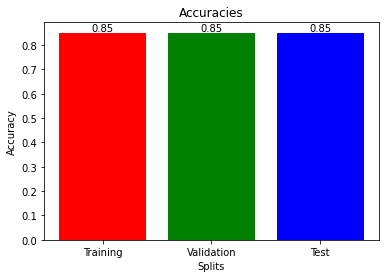

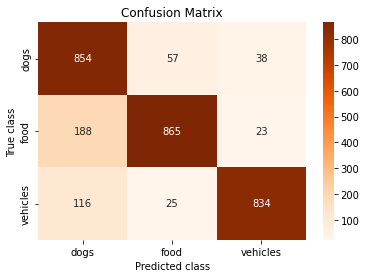

In [13]:
ViT_base_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViT_base_model.parameters(), lr=1e-5)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=ViT_base_model, criterion=criterion,
                                                                                    optimizer=optimizer)
LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=ViT_base_model)

## Result comparision of Vision Transformer (ViT)  with VGG and ResNet

<b>VGG Results:</b> Accuracy on the testing dataset = 93.83, Precision = 0.94, Recall = 0.94, Fscore = 0.94

<b>ResNet Results:</b> Accuracy on the testing dataset = 92.27, Precision = 0.92, Recall = 0.92, Fscore = 0.92

<b>Vision Transformer (ViT) Results:</b> Accuracy on the testing dataset = 0.85, Precision = 0.86, Recall = 0.85, Fscore = 0.85


In [14]:
import timm

class EfficientNet(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNet, self).__init__()
        # Load the pre-trained EfficientNet-B0 model
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        # Modify the classifier head to match the number of classes
        in_features = self.efficientnet.classifier.in_features
        self.efficientnet.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [15]:
Efficientnet_b0_model = EfficientNet()
print(Efficientnet_b0_model)

EfficientNet(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_s

Epoch 1/10, Train Loss: 0.8003, Validation Loss: 0.5445, Test Loss: 0.5418
Epoch 2/10, Train Loss: 0.3908, Validation Loss: 0.3028, Test Loss: 0.2984
Epoch 3/10, Train Loss: 0.2445, Validation Loss: 0.2128, Test Loss: 0.2062
Epoch 4/10, Train Loss: 0.1834, Validation Loss: 0.1712, Test Loss: 0.1675
Epoch 5/10, Train Loss: 0.1504, Validation Loss: 0.1497, Test Loss: 0.1487
Epoch 6/10, Train Loss: 0.1245, Validation Loss: 0.1361, Test Loss: 0.1339
Epoch 7/10, Train Loss: 0.1084, Validation Loss: 0.1268, Test Loss: 0.1260
Epoch 8/10, Train Loss: 0.0937, Validation Loss: 0.1180, Test Loss: 0.1199
Epoch 9/10, Train Loss: 0.0809, Validation Loss: 0.1131, Test Loss: 0.1136
Epoch 10/10, Train Loss: 0.0740, Validation Loss: 0.1070, Test Loss: 0.1078
Finished Training

Time to train: 4min 13sec


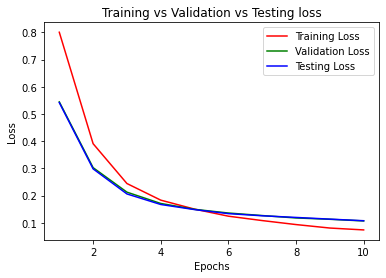

Accuracy on the testing dataset = 0.96
Precision = 0.96
Recall = 0.96
Fscore = 0.96


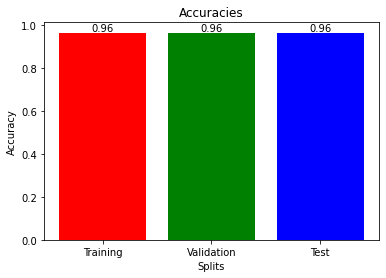

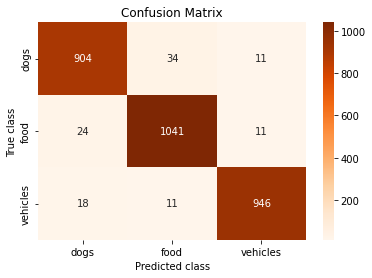

In [16]:
Efficientnet_b0_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Efficientnet_b0_model.parameters(), lr=1e-5)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=Efficientnet_b0_model, criterion=criterion,
                                                                                    optimizer=optimizer)
LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=Efficientnet_b0_model)

## Result comparision of EfficientNet with VGG and ResNet

<b>VGG Results:</b> Accuracy on the testing dataset = 93.83, Precision = 0.94, Recall = 0.94, Fscore = 0.94

<b>ResNet Results:</b> Accuracy on the testing dataset = 92.27, Precision = 0.92, Recall = 0.92, Fscore = 0.92

<b>EfficientNet Results:</b> Accuracy on the testing dataset = 0.96, Precision = 0.96, Recall = 0.96, Fscore = 0.96


# References

1. https://pandas.pydata.org/docs/
1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://pytorch.org/vision/main/models/vision_transformer.html
1. https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c
1. Data Loading and Processing is based on CSE 676 Deep Learning Assignment 1 Part 1 and Bonus submission by Nikhil Gupta